# Weave smart meter data (beta)

The UK energy regulator OFGEM requires distribution network operators (DNOs) in the UK to publish aggregated smart meter readings from their networks. We've taken that data and made it easier to use by republishing it as GeoParquet files.

This notebook gives an overview of how you can use that data, with examples of code using PyArrow and GeoPandas.

Note: the data used here comes from a beta release of our data pipeline, which only contained data for two DNOs and from Jan '24 to Dec '24. We have subsequently released a full production pipeline, which you can find documentation for in [/docs/smart-meter-examples-v1.0.ipynb]. We also released an earlier [alpha prototype](https://github.com/centre-for-ai-and-climate/lv-feeder-smart-meter-data/blob/main/geoparquet-example.ipynb), which included data from four DNOs, but only for Feb '24.

This data is much bigger than our alpha prototype, so rather than publishing it as a single parquet file, we have partitioned it into smaller monthly files.

## Setup
This is a jupyter python notebook, you're looking at the saved output from us running it on our own machine. 

To run it on your machine you need a few dependencies installed - particularly a relatively recent version of Jupyter and Geopandas. There are many ways to achieve this in the modern python ecosystem, but we like [UV](https://docs.astral.sh/uv/getting-started/installation/) and include in this repository `pyproject.toml` and `uv.lock` files which should make it easy to replicate our development environment. 

Once you have UV installed, you can simply run the jupyter server:
```shell
uv run jupyter notebook
```

On the first run it will download the required dependencies, including the version of python we specify, install those into a virtual environment and then launch a jupyter server, which in turn should open a browser window. In that window, you should see a Jupyter interface, from which you can open the `/docs` folder and then find this file.

## How do I get the data?
Just like with our alpha prototype, you can read it straight into a GeoDataFrame with GeoPandas:

```python
import geopandas as gpd
gdf = gpd.read_parquet("s3://weave.energy/beta/smart-meter")
```

**However**, unless you have a *lot* of RAM (128GB+), this is probably not a good idea. There is 10x the data now, so it eats your memory for breakfast. 

Instead, you're likely going to want to be selective about what you load.

### Using GeoPandas
All of the examples we previously gave for filtering data should work just the same. 

Let's use an example of selecting a single settlement period and plotting it on a pretty map:

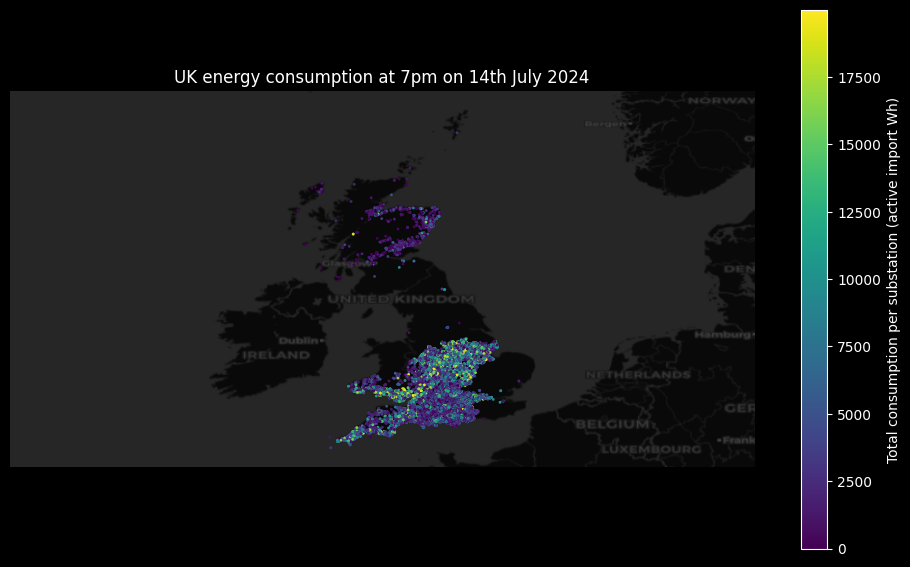

In [2]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Kickoff of the UEFA Euro 2024 final, in case you were wondering
settlement_period = pd.Timestamp("2024-07-14 20:00Z")

gdf = gpd.read_parquet("s3://weave.energy/beta/smart-meter", filters=[("data_collection_log_timestamp", "=", settlement_period)])
# Sum up energy consumption per secondary substation
substations = gdf.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry", crs=4326)
# There are still issues with extreme outliers, so we filter them out
substations = substations[substations["total_consumption_active_import"] < 20000]

ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=1, legend=True, legend_kwds={"label": "Total consumption per substation (active import Wh)"}, figsize=(12, 7))
ax.set_title("UK energy consumption at 7pm on 14th July 2024")
ax.set_axis_off()
ax.set_xlim(-18, 10)
ax.set_ylim(49.25, 61.5)
ax.set_facecolor("#1B2526")
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)


This takes a tiny bit longer than it did before because under the hood, geopandas has to load the metadata for each of the 10 partitions to find the right parts of the parquet file to download, but it ultimately still results in a very manageable dataset in memory.

We can improve the performance here by writing a folder-level `_metadata` file so you don't need to read one per-partition, but it's not completely standard. GeoParquet has also not yet agreed how it will write geospatial metadata to such a file, so we'll have to experiment a bit to make sure things are compatible.

Note you can use a whole range of filtering expressions here: `=` or `==`, `!=`, `<`, `>`, `<=`, `>=`, `in` and `not in`, as well as combining multiple expressions using boolean logic (see [PyArrow's docs](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table) for more details).

Some more examples you might want to try:

### By bounding box

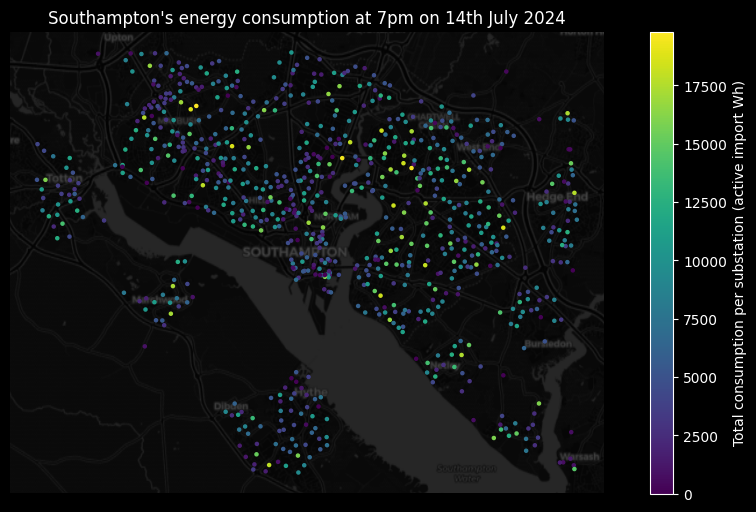

In [3]:
# The area around Southampton, in min_x, min_y, max_x, max_y format
# (Pro tip: ChatGPT is excellent for creating these)
bbox = (-1.5,50.85,-1.3,50.95)
gdf = gpd.read_parquet("s3://weave.energy/beta/smart-meter", bbox=bbox, filters=[("data_collection_log_timestamp", "=", pd.Timestamp("2024-07-14 20:00Z"))])
substations = gdf.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry", crs=4326)
substations = substations[substations["total_consumption_active_import"] < 20000]
ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=5, legend=True, legend_kwds={"label": "Total consumption per substation (active import Wh)"}, figsize=(12, 6))
ax.set_title("Southampton's energy consumption at 7pm on 14th July 2024")
ax.set_axis_off()
ax.set_facecolor("#1B2526")
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)

As before, the cool thing with parquet is that we can "push down" the filtering to the downloading step, so less data has to go over the wire, and with geoparquet, this includes these bounding box filters.

As before, we've sorted the data by:
- Timestamp
- DNO
- Substation 
- Feeder

So the use of any of those columns in a filter should be pretty efficient because it can restrict the data it has to scan.

### By secondary substation id

By pulling out a single substation, we can take a closer look at the actual shape of the data, especially now that we have nearly 10 months of it.

In [4]:
gdf = gpd.read_parquet("s3://weave.energy/beta/smart-meter", filters=[("secondary_substation_unique_id", "==", "SSEN-6400603160")])
gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47457 entries, 0 to 47456
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       47457 non-null  object             
 1   dno_alias                        47457 non-null  object             
 2   aggregated_device_count_active   47124 non-null  float64            
 3   total_consumption_active_import  47124 non-null  float64            
 4   data_collection_log_timestamp    47457 non-null  datetime64[ms, UTC]
 5   geometry                         47457 non-null  geometry           
 6   secondary_substation_unique_id   47457 non-null  object             
 7   lv_feeder_unique_id              47457 non-null  object             
dtypes: datetime64[ms, UTC](1), float64(2), geometry(1), object(4)
memory usage: 2.9+ MB


See [our FAQ](https://docs.google.com/document/d/16tOUcaxGzSzuTw2JyR2O5yp_q7VM2J4jTV3lAkV1skQ/edit?tab=t.0#heading=h.23nyfir20pt1) for what all these fields mean and some caveats around using them, but the key thing to understand is that we have Wh energy consumption, per half-hour, for every low-voltage feeder.

We can see a bit more of an overview of how that data looks here with some aggregation:

In [5]:
gdf.groupby("lv_feeder_unique_id").agg({
    "lv_feeder_unique_id": ["count"],
    "data_collection_log_timestamp": ["min", "max"],
    "aggregated_device_count_active": ["min", "max"],
    "total_consumption_active_import": ["min", "max"]
})

lv_feeder_unique_id data_collection_log_timestamp  \
                                  count                           min   
lv_feeder_unique_id                                                     
SSEN-640060316002                 16154     2024-02-12 00:30:00+00:00   
SSEN-640060316003                 16154     2024-02-12 00:30:00+00:00   
SSEN-640060316004                 15149     2024-02-12 00:30:00+00:00   

                                              aggregated_device_count_active  \
                                          max                            min   
lv_feeder_unique_id                                                            
SSEN-640060316002   2025-01-17 00:00:00+00:00                            9.0   
SSEN-640060316003   2025-01-17 00:00:00+00:00                           27.0   
SSEN-640060316004   2025-01-17 00:00:00+00:00                            5.0   

                           total_consumption_active_import                
                       max                             min           max  
lv_feeder_unique_id                                                       
SSEN-640060316002     74.0                           710.0  2.123800e+04  
SSEN-640060316003    250.0                          2395.0  4.295011e+09  
SSEN-640060316004     26.0                           290.0  9.100000e+03

So the substation we've chosen has three low-voltage feeders, and we've got data starting in Feb and running until a few days ago. The feeders themselves vary a lot in terms of how many houses they serve and therefore the total consumption you might see.

Note also how the number of houses (devices) can vary over time! There are power cuts and other problems which prevent meters from providing their data, so we have to be careful when we use the data.

Lets look at this consumption visually:

<Axes: title={'center': 'Daily Wh consumption per low-voltage feeder for a substation in Southampton'}, xlabel='Date', ylabel='Consumption (Wh)'>

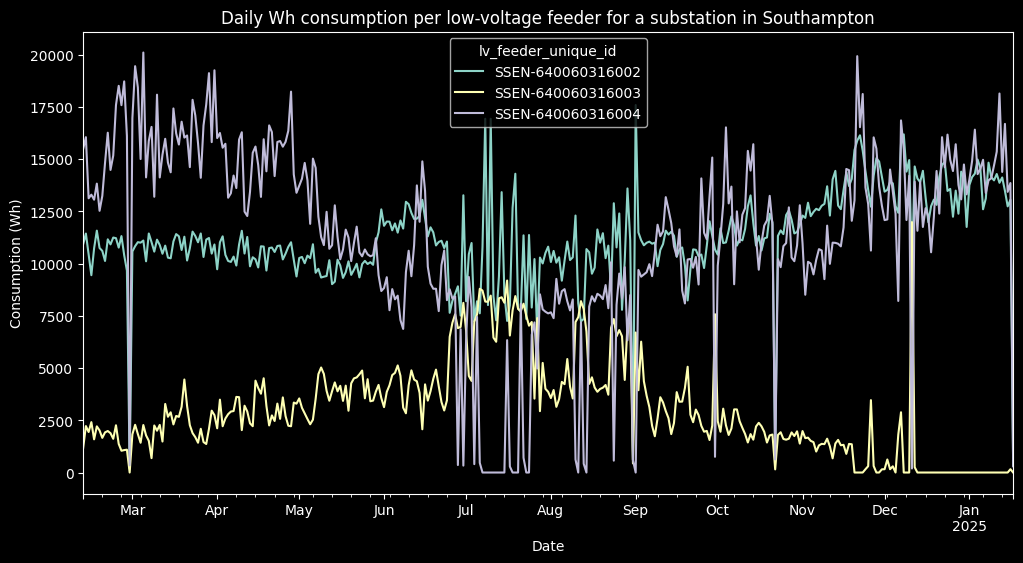

In [7]:
# Still some issues with enourmous outliers
gdf = gdf[gdf["total_consumption_active_import"] < 20000]
# There are some issues around the clock change in October with duplicated settlement periods
deduped_gdf = gdf.drop_duplicates(subset=["data_collection_log_timestamp", "lv_feeder_unique_id"]).copy()
deduped_gdf["normalised_consumption"] = deduped_gdf["total_consumption_active_import"] / deduped_gdf["aggregated_device_count_active"]
timeseries = deduped_gdf.pivot(index="data_collection_log_timestamp", columns="lv_feeder_unique_id", values="normalised_consumption")
timeseries.resample("d").sum().plot(figsize=(12,6), xlabel="Date", ylabel="Consumption (Wh)", title="Daily Wh consumption per low-voltage feeder for a substation in Southampton")

This code highlights some of the issues you're likely to encounter when working with the data:

- Outliers. There are some extreme values in the data which are not realistic. We're working with the DNOs to understand where these come from and what we can do about them.
- At the daylight savings switchover, some rows are duplicated, giving you two values for 1am on the 27th October, and a doubled value for 1:30am
- Some pretty big gaps in the data, e.g. in mid July. That could be expected to be a time of lower energy use, but not zero for days on end! Unfortunately, our conversations with DNOs have revealed that this was due to a bug on their end, which cannot now be rectified, so that data is lost.

## Using PyArrow
In developing our data pipeline, we've become more familiar with PyArrow - the Python API of Apache Arrow - which underpins GeoPandas parquet support. In their own words:

> Apache Arrow is a development platform for in-memory analytics. It contains a set of technologies that enable big data systems to store, process and move data fast.

We have found it extremely useful when dealing with smart meter data, partly because it is faster, but also because it's Parquet toolkit is more extensive.

If you've gotten past the stage of playing with the data in a dataframe and want to productionise something, it could be a good option:

In [75]:
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
import geopandas as gpd

# You can apply filters to a dataset just like in geopandas read_parquet, except the
# datatypes are pyarrow's. Here's an example of filtering by a timestamp
settlement_period = pa.scalar(datetime(2024, 7, 14, 20, 0, 0), type=pa.timestamp("ms", tz="UTC"))
ds = pq.ParquetDataset("s3://weave.energy/beta/smart-meter", filters=[["data_collection_log_timestamp", "=", settlement_period]])
# ds has useful overview properties like schema, files, etc
# When you want to read some data (and optionally turn it into a Pandas dataframe), it's
# easy. e.g.
gdf = gpd.GeoDataFrame.from_arrow(ds.read())
# Now you can work with gdf as you would with any other GeoDataFrame
# Plus, all the filters we listed above work just the same.
gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       66807 non-null  object             
 1   dno_alias                        66807 non-null  object             
 2   aggregated_device_count_active   60657 non-null  float64            
 3   total_consumption_active_import  60657 non-null  float64            
 4   data_collection_log_timestamp    66807 non-null  datetime64[ms, UTC]
 5   geometry                         66807 non-null  geometry           
 6   secondary_substation_unique_id   66807 non-null  object             
 7   lv_feeder_unique_id              66807 non-null  object             
dtypes: datetime64[ms, UTC](1), float64(2), geometry(1), object(4)
memory usage: 4.1+ MB
